In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 3
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

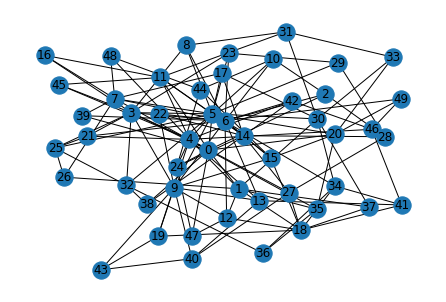

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

Distribuzione della connettività dei nodi

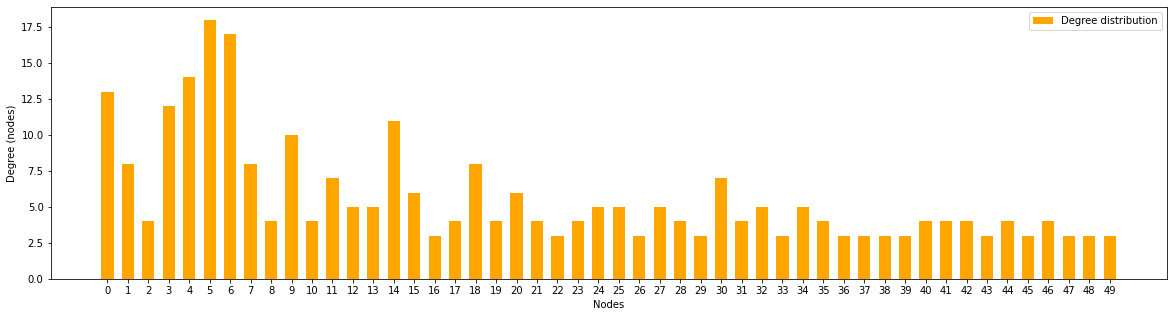

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(G.nodes, [d for n,d in G.degree], width=0.6, 
          align='center', color='orange', label='Degree distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Degree (nodes)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

Estrazione della matrice di adiacenza A

In [5]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [6]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [7]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)
pS = autovettoriP[0]
if pS[0] < 0:
    pS = -pS
#np.dot(np.transpose(matrix),autovettori[0])

In [8]:
autovaloriP

array([ 1.        ,  0.69714323,  0.66783141, -0.68772991,  0.58052113,
        0.55945219,  0.5355459 ,  0.53322762, -0.61215941, -0.58784636,
       -0.57951529,  0.46967682,  0.44764856,  0.41526122,  0.39451417,
        0.36723004,  0.34567315, -0.53485234, -0.51223758, -0.48727138,
       -0.4773104 , -0.45378086, -0.44223996, -0.4212978 , -0.39378558,
       -0.37359784,  0.29430441,  0.2856838 , -0.33595559, -0.30431062,
       -0.29468011, -0.27319559, -0.24096931,  0.22907238,  0.20332434,
       -0.1834591 , -0.15700297,  0.16360291,  0.15566044,  0.13858542,
       -0.12151868,  0.10274391,  0.07809587,  0.04849592, -0.0905352 ,
       -0.07408466, -0.05461447, -0.03529149,  0.01281538,  0.00313228])

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [9]:
matrixL = np.identity(N) - matrixP

In [10]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)
pS_L = autovettoriL[0]
if pS_L[0] < 0:
    pS_L = -pS_L

In [11]:
autovaloriL

array([5.55111512e-17, 3.02856767e-01, 3.32168589e-01, 1.68772991e+00,
       4.19478872e-01, 4.40547808e-01, 4.64454098e-01, 4.66772384e-01,
       1.61215941e+00, 1.58784636e+00, 1.57951529e+00, 5.30323182e-01,
       5.52351441e-01, 5.84738783e-01, 6.05485833e-01, 6.32769962e-01,
       6.54326851e-01, 1.53485234e+00, 1.51223758e+00, 1.48727138e+00,
       1.47731040e+00, 1.45378086e+00, 1.44223996e+00, 1.42129780e+00,
       1.39378558e+00, 1.37359784e+00, 7.05695587e-01, 7.14316204e-01,
       1.33595559e+00, 1.30431062e+00, 1.29468011e+00, 1.27319559e+00,
       1.24096931e+00, 7.70927624e-01, 7.96675660e-01, 1.18345910e+00,
       8.36397093e-01, 8.44339556e-01, 8.61414576e-01, 1.15700297e+00,
       8.97256093e-01, 9.21904129e-01, 9.51504080e-01, 1.12151868e+00,
       1.09053520e+00, 1.07408466e+00, 1.05461447e+00, 1.03529149e+00,
       9.87184619e-01, 9.96867724e-01])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [12]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [14]:
FiedlerValue = round(min(autovaloriL[1:]), i)

In [15]:
pS = np.round(pS, i)

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [16]:
walker_per_node = 15

In [17]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [18]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

# history[0] = [[walker_per_node] * len(G.nodes)]
# history[1] = [[walker_per_node] * len(G.nodes)]
# history[2] = [[walker_per_node] * len(G.nodes)]
time_steps = int(1e3)

In [19]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 31.197787284851074 seconds


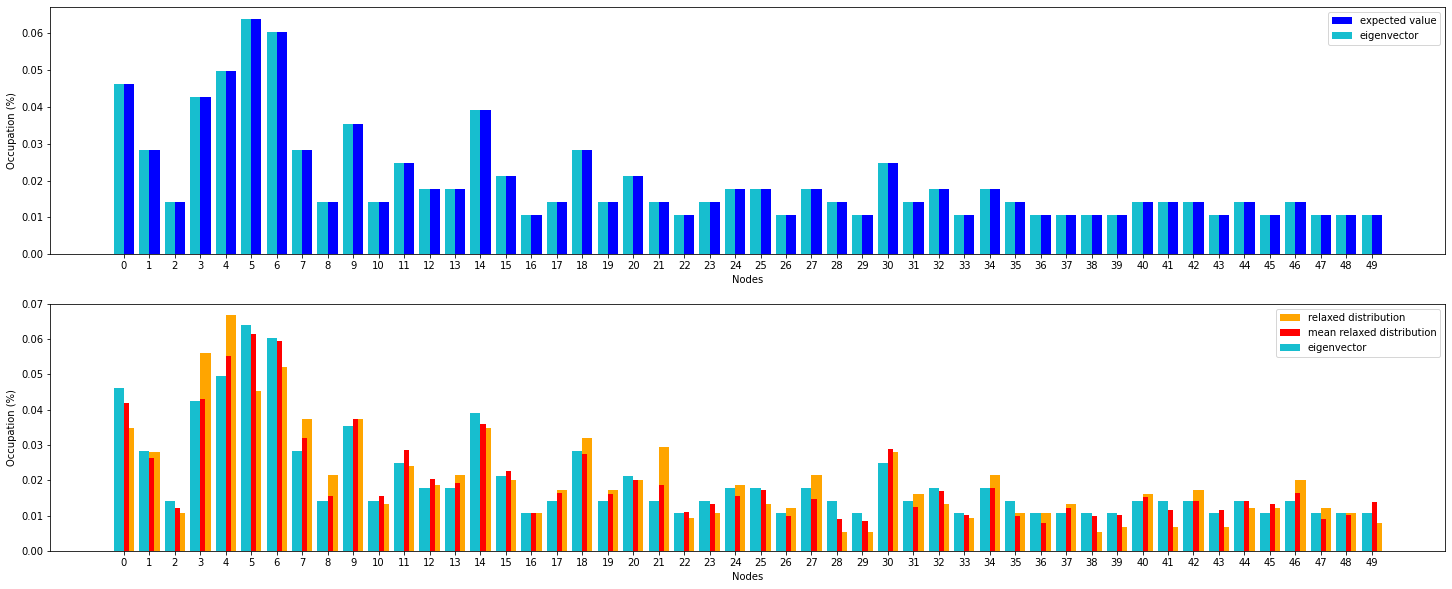

In [42]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [d for n, d in G.degree()]
pSNorm = [h/sum(pSNorm) for h in pSNorm]

hMean = [[(h1+h2+h3)/(sum(history[0][-1] + history[1][-1] + history[2][-1])) 
         for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSNorm) for h in pSNorm], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

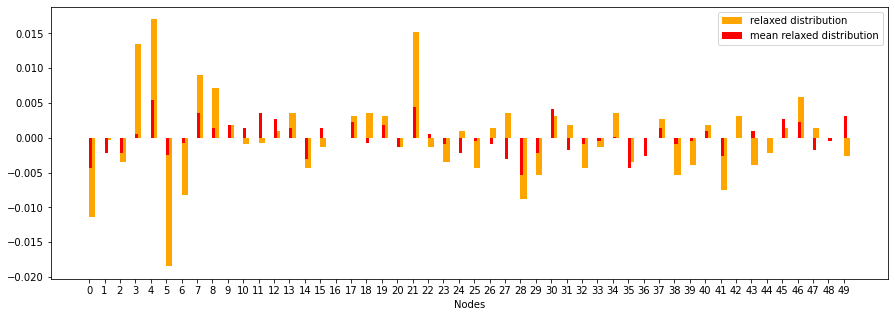

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k
                    for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
          width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
# ax.set_ylabel("Occupation (%)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

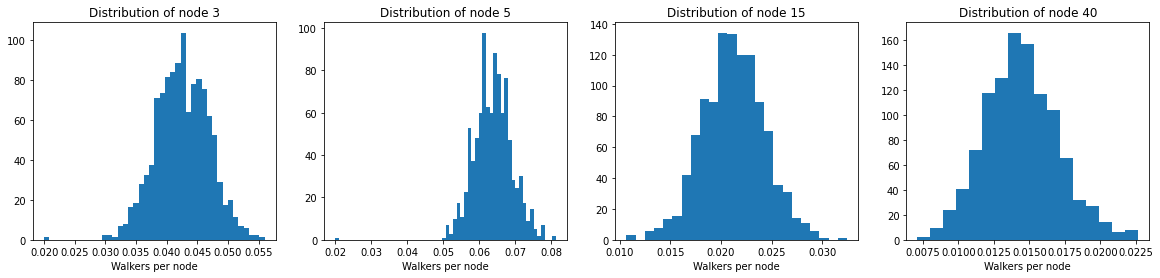

In [45]:
nodes = [3, 5, 15, 40]
p_node = []

fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(5*len(nodes), 4))

histo = history[0]

for i in range(len(nodes)):
    p_node += [[h[nodes[i]] for h in histo]]
    ax[i].hist(p_node[i], bins = int(walker_per_node*N*max(p_node[i])), density = True)
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_xlabel("Walkers per node")

plt.show()

In [23]:
for i in range(len(nodes)):
    print("DIstribution for node", nodes[i], ":")
    print(sum(p_node[i])/time_steps)
    print(pSNorm[nodes[i]]*N*walker_per_node)
    print()

DIstribution for node 5 :
47.618
47.87234042553192

DIstribution for node 15 :
15.849
15.957446808510639

DIstribution for node 25 :
13.032
13.297872340425533

DIstribution for node 40 :
11.022
10.638297872340425



In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(6*len(nodes), 4))

time_range = hMean
index = np.arange(0, len(time_range), 10)

for i in range(len(nodes)):
    ax[i].plot(index, [time_range[ind][i]/(walker_per_node*N) for ind in index])
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_ylabel("Walkers per node")
    ax[i].set_xlabel("Time steps")

plt.show()

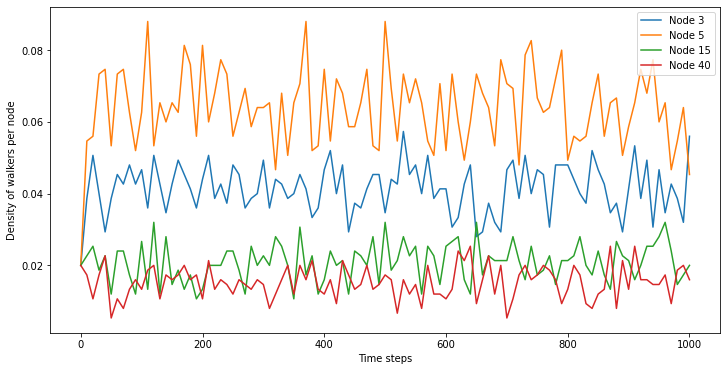

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))

time_range = history[0]
index = np.arange(0, len(time_range), 10)

for i in nodes: #list(G.nodes)[0:3]:
    plt.plot(index, [time_range[ind][i]/(walker_per_node*N) for ind in index], label = f"Node {i}")
#     plt.plot(index, [time_range[ind][i] for ind in index])
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

# Note:

* aggiungere fit su distribuzioni di walkers

* sistema grafica concentrazioni di individui su ogni nodo

* fare grafico per fittare valore di Fiedler